# Comparaison entre SDSS (Wen,Han and Liu 2012) et DESI Legacy Imaging Surveys (Wen and Han 2024)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import math
import scipy
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table
from astropy.cosmology import Planck13
import pickle
import os
import random

In [2]:
from gem_astmatch_modified import match_celestial_objects_list_deg,match_celestial_objects,create_skycoord_from_fits,do_celest_match_fits   

## Import catalogues

Fonction pour passer de .fit à un dataframe (REMARQUE : Le programme ne semble pas fonctionner pour certains fits binary → dans le doute télécharger des fits ascii) : 

In [3]:
# Transfome la première extension d'un fichier FITS en un DataFrame pandas
def fits_to_dataframe(fits_file):
    with fits.open(fits_file) as hdul:
        data = hdul[1].data 
        data_df = pd.DataFrame(data)
    return data_df

In [4]:
path_SDSS_2015 = '../SDSS_ROSAT/Update_2015_Wen_2012_SDSS_ascii.fit' # Si on utilise l'update de 2015, on dispose en plus de r500
path_SDSS_2012 = '../SDSS_ROSAT/Wen_2012_SDSS_ascii.fit' 
path_DESI = '../DESI_eRass/DESI_Legacy_Wen_2024.fit'

In [5]:
table_SDSS_2015 = fits_to_dataframe(path_SDSS_2015)
table_SDSS_2012 = fits_to_dataframe(path_SDSS_2012)
table_DESI = fits_to_dataframe(path_DESI)

In [6]:
table_DESI

,_RAJ2000,_DEJ2000,ID,n_Name,Name,RAJ2000,DEJ2000,zCl,f_zCl,zmag,...,logMs,r500,lam500,M500,Ngal,Gamma,e_Gamma,imag_,Cat,recno
0,0.00046,-37.47628,1,,J000000.1-372835,0.00046,-37.47628,0.1364,0,15.377,...,11.49,0.766,25.79,1.17,14,0.0,0.0,1,WHY18,1
1,0.00135,-56.58835,2,WH-,J000000.3-563518,0.00135,-56.58835,0.1957,0,15.712,...,11.70,0.625,23.24,1.06,7,0.0,0.0,1,,2
2,0.00172,-39.32369,3,,J000000.4-391925,0.00172,-39.32369,0.3580,0,17.713,...,11.41,0.526,15.90,0.73,7,0.0,0.0,1,Y21,3
3,0.00201,2.31980,4,,J000000.5+021911,0.00201,2.31980,0.4282,1,18.043,...,11.55,0.612,23.40,1.07,13,0.0,0.0,1,redMaPPer,4
4,0.00260,-59.01297,5,WH-,J000000.6-590047,0.00260,-59.01297,0.1380,0,14.993,...,11.69,0.606,15.71,0.73,7,0.0,0.0,1,,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1581174,359.99667,4.99211,1581175,WH-,J235959.2+045932,359.99667,4.99211,0.5948,0,19.184,...,11.37,0.420,10.99,0.51,6,0.0,0.0,2,,1581175
1581175,359.99680,21.78514,1581176,,J235959.2+214707,359.99680,21.78514,0.4050,1,17.259,...,11.78,0.658,31.73,1.43,9,0.0,0.0,2,WHL,1581176
1581176,359.99817,10.04951,1581177,,J235959.6+100258,359.99817,10.04951,0.7919,0,18.904,...,11.88,0.621,33.23,1.50,8,0.0,0.0,2,CFSFDP,1581177
1581177,359.99847,-6.34469,1581178,WH-,J235959.6-062041,359.99847,-6.34469,1.0333,0,20.952,...,11.18,0.439,13.12,0.61,6,0.0,0.0,2,,1581178


In [7]:
def SDSS_2012_scaling_relation_M200_RL(RL_list):
    M200_list = []
    for RL_ in RL_list:
        log_M200 = -1.49 + 1.17 * np.log10(RL_) #  the formula used is the equation 2 (p.3) of Wen et al. 2012 : the uncertainties are not taken into account !
        M200 = 10**log_M200
        M200_list.append(M200)
    return M200_list

    M200_SDSS = SDSS_2012_scaling_relation_M200_RL(table_SDSS['RL_'].tolist()) # Each mass is in 10^14 MSun
    table_SDSS['M200'] = M200_SDSS

def SDSS_Update_2015_scaling_relation_M500_RL(RL_list):
    M500_list = []
    for RL_ in RL_list:
        log_M500 = -1.37 + 1.08 * np.log10(RL_) #  the formula used is the equation 17 (p.7) of Wen et Han. 2015 : the uncertainties are not taken into account !
        M500 = 10**log_M500
        M500_list.append(M500)
    return M500_list


## Comparaison SDSS_Update_2015 et DESI_Legacy_2024

In [8]:
M500SDSS2015 = SDSS_Update_2015_scaling_relation_M500_RL(table_SDSS_2015['RL_500'].tolist()) # Each mass is in 10^14 MSun
table_SDSS_2015['M500'] = M500SDSS2015

In [9]:
table_SDSS_2015

,_Glon,_Glat,WHL,f_WHL,RAJ2000,DEJ2000,zph,zsp,rmag,r200,RL_,N200,r500,RL_500,N500sp,N500,Sloan,M500
0,110.449770,-29.412918,J000000.6+321233,,0.00236,32.20925,0.1274,0.0000,14.92,1.72,70.63,24,1.01,68.28,0,19,Sloan\r,4.083542
1,100.049559,-55.283431,J000002.3+051718,,0.00957,5.28827,0.1696,0.1694,16.20,0.94,17.48,9,0.72,24.46,1,9,Sloan\r,1.347513
2,93.207365,-63.412252,J000003.1-033245,*,0.01276,-3.54578,0.5968,0.5973,20.14,1.00,19.19,11,0.83,49.33,2,13,Sloan\r,2.874485
3,110.203228,-30.366812,J000003.3+311354,,0.01377,31.23175,0.5428,0.5293,20.17,0.87,14.27,8,0.63,25.43,2,9,Sloan\r,1.405316
4,110.350581,-29.827793,J000003.5+314708,,0.01475,31.78564,0.0932,0.0916,15.18,0.94,16.97,9,0.69,21.14,1,11,Sloan\r,1.151101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132679,107.667888,-38.665737,J235956.9+224030,,359.98712,22.67506,0.3590,0.3805,18.27,1.00,19.46,11,0.63,22.41,1,5,Sloan\r,1.225963
132680,104.152271,-47.689671,J235958.4+131748,,359.99329,13.29671,0.1710,0.1699,16.57,0.91,14.23,11,0.61,12.12,1,6,Sloan\r,0.631223
132681,96.879786,-59.541787,J235958.8+004206,,359.99500,0.70175,0.0741,0.0823,14.89,1.01,19.64,11,0.74,18.39,7,7,Sloan\r,0.990258
132682,107.386151,-39.528437,J235959.2+214706,,359.99677,21.78513,0.4303,0.4051,18.90,1.00,19.17,11,0.58,15.68,1,5,Sloan\r,0.833631


In [10]:
table_DESI_filtered = table_DESI[table_DESI['Cat'].str.contains("WHL", na=False)] # On récupère les objets de la table DESI qui sont dans la table SDSS (WHL = Wen,Hal,Liu)
print(len(table_DESI_filtered))

96469


In [11]:
table_SDSS_filtered = table_SDSS_2015[table_SDSS_2015['WHL'].isin(table_DESI_filtered['Name'].tolist())] 
print(len(table_SDSS_filtered)) # Pourquoi on ne récupère pas tous les clusters 'table_DESI_filtered'? → ils sont censés tous correspondre à ceux de SDSS

table_DESI_filtered = table_DESI_filtered[table_DESI_filtered['Name'].isin(table_SDSS_filtered['WHL'].tolist())] 
print(len(table_DESI_filtered))


44281
44281


In [12]:
# Align the rows of table_DESI_filtered to match the order of table_SDSS_filtered['WHL']
table_DESI_filtered = table_DESI_filtered.set_index('Name').loc[table_SDSS_filtered['WHL']].reset_index()
table_DESI_filtered['Name'].tolist() == table_SDSS_filtered['WHL'].tolist()

True

In [13]:
table_SDSS_filtered

,_Glon,_Glat,WHL,f_WHL,RAJ2000,DEJ2000,zph,zsp,rmag,r200,RL_,N200,r500,RL_500,N500sp,N500,Sloan,M500
1,100.049559,-55.283431,J000002.3+051718,,0.00957,5.28827,0.1696,0.1694,16.20,0.94,17.48,9,0.72,24.46,1,9,Sloan\r,1.347513
2,93.207365,-63.412252,J000003.1-033245,*,0.01276,-3.54578,0.5968,0.5973,20.14,1.00,19.19,11,0.83,49.33,2,13,Sloan\r,2.874485
3,110.203228,-30.366812,J000003.3+311354,,0.01377,31.23175,0.5428,0.5293,20.17,0.87,14.27,8,0.63,25.43,2,9,Sloan\r,1.405316
10,110.386640,-29.742048,J000006.6+315235,,0.02762,31.87626,0.2134,0.2092,17.11,1.18,28.58,15,0.77,23.97,3,10,Sloan\r,1.318383
14,106.420308,-42.341643,J000007.7+185245,,0.03208,18.87909,0.4347,0.4085,18.95,1.03,20.47,12,0.70,29.03,1,11,Sloan\r,1.621343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132671,109.853055,-31.444988,J235951.3+300648,*,359.96356,30.11333,0.4934,0.5005,19.85,1.00,19.31,12,0.66,29.71,1,12,Sloan\r,1.662397
132675,85.495755,-68.801597,J235953.3-094551,,359.97192,-9.76429,0.2749,0.2601,18.08,0.85,12.31,8,0.56,12.88,1,7,Sloan\r,0.674076
132677,88.063793,-67.272266,J235953.5-075731,,359.97290,-7.95870,0.3634,0.3452,18.07,1.10,23.68,13,0.74,31.90,1,12,Sloan\r,1.795122
132678,83.307022,-69.937532,J235954.1-110813,,359.97543,-11.13708,0.3978,0.0000,19.02,1.02,20.28,11,0.64,19.06,0,6,Sloan\r,1.029278


In [14]:
table_DESI_filtered

,Name,_RAJ2000,_DEJ2000,ID,n_Name,RAJ2000,DEJ2000,zCl,f_zCl,zmag,...,logMs,r500,lam500,M500,Ngal,Gamma,e_Gamma,imag_,Cat,recno
0,J000002.3+051718,0.00959,5.28825,18,,0.00959,5.28825,0.1694,1,15.412,...,11.75,0.708,29.06,1.32,11,0.00,0.00,1,WHL,18
1,J000003.1-033245,0.01275,-3.54574,25,,0.01275,-3.54574,0.5973,1,18.010,...,11.97,0.851,72.67,3.20,36,0.06,0.05,1,WHL,25
2,J000003.3+311354,0.01373,31.23177,946500,,0.01373,31.23177,0.5294,1,18.461,...,11.50,0.556,20.06,0.92,10,0.00,0.00,2,WHL,946500
3,J000006.6+315235,0.02761,31.87627,946541,,0.02761,31.87627,0.2117,1,16.043,...,11.69,0.918,54.31,2.41,21,0.00,0.00,2,WHL,946541
4,J000007.7+185245,0.03207,18.87909,946551,,0.03207,18.87909,0.4086,1,17.660,...,11.63,0.587,19.01,0.87,6,0.00,0.00,2,WHL,946551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44276,J235951.3+300648,359.96356,30.11331,1581102,,359.96356,30.11331,0.5005,1,18.425,...,11.50,0.603,25.18,1.15,13,0.00,0.00,2,WHL,1581102
44277,J235953.3-094551,359.97192,-9.76426,946398,,359.97192,-9.76426,0.2601,1,16.795,...,11.57,0.566,18.76,0.86,9,0.00,0.00,1,WHL,946398
44278,J235953.5-075731,359.97293,-7.95870,946404,,359.97293,-7.95870,0.3452,1,16.816,...,11.74,0.707,31.92,1.44,13,0.00,0.00,1,WHL,946404
44279,J235954.1-110813,359.97546,-11.13707,1581138,,359.97546,-11.13707,0.4104,0,17.794,...,11.55,0.720,26.59,1.21,15,0.00,0.00,2,WHL,1581138


In [15]:
M_500_SDSS_2015 = np.array(table_SDSS_filtered['M500'].tolist()) # Each mass is in 10^14 MSun
M_500_DESI = np.array(table_DESI_filtered['M500'].tolist()) # Each mass is in 10^14 MSun

Richness_500_2015 = np.array(table_SDSS_filtered['RL_500'].tolist())
Richness_500_DESI = np.array(table_DESI_filtered['lam500'].tolist())

diff_mass_normalisée = M_500_DESI - M_500_SDSS_2015 / ((M_500_DESI + M_500_SDSS_2015)/2) * 100 # On divise par la moyenne pour avoir un écart relatif
diff_mass = M_500_DESI - M_500_SDSS_2015
diff_richness_normalisée = Richness_500_DESI - Richness_500_2015 / ((Richness_500_DESI + Richness_500_2015)/2) * 100
diff_richness = Richness_500_DESI - Richness_500_2015

Text(0.5, 1.0, 'Différence de M500, 10^14 MSun, entre SDSS_Update_2015 et DESI_2024')

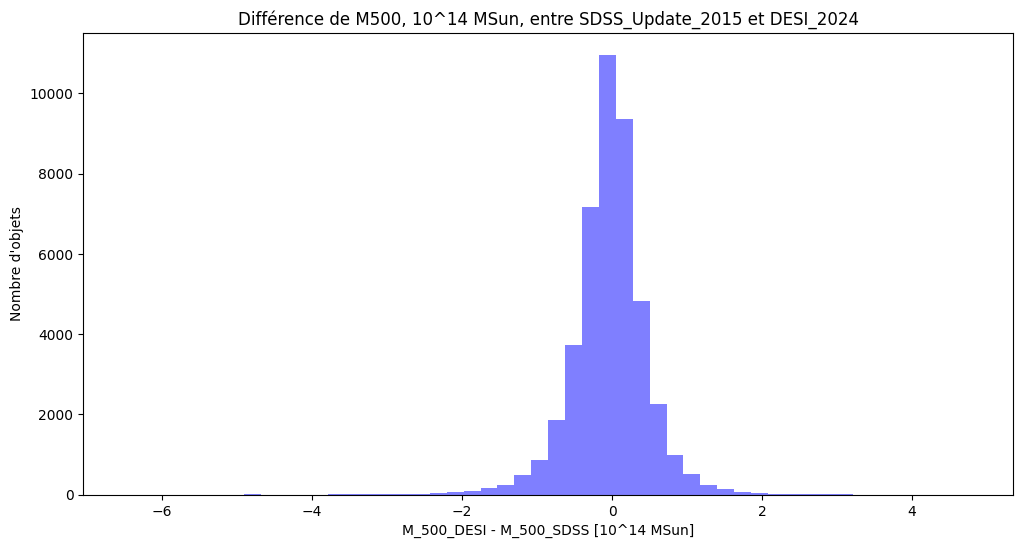

In [16]:
plt.figure(figsize=(12, 6))
plt.hist(diff_mass, bins=50, color='blue', alpha=0.5)
plt.xlabel('M_500_DESI - M_500_SDSS [10^14 MSun]')
plt.ylabel('Nombre d\'objets')
plt.title('Différence de M500, 10^14 MSun, entre SDSS_Update_2015 et DESI_2024')

'output_path = os.path.join(folder_plots, "histogramme_diff_M500.png")\nplt.savefig(output_path, dpi=300)'

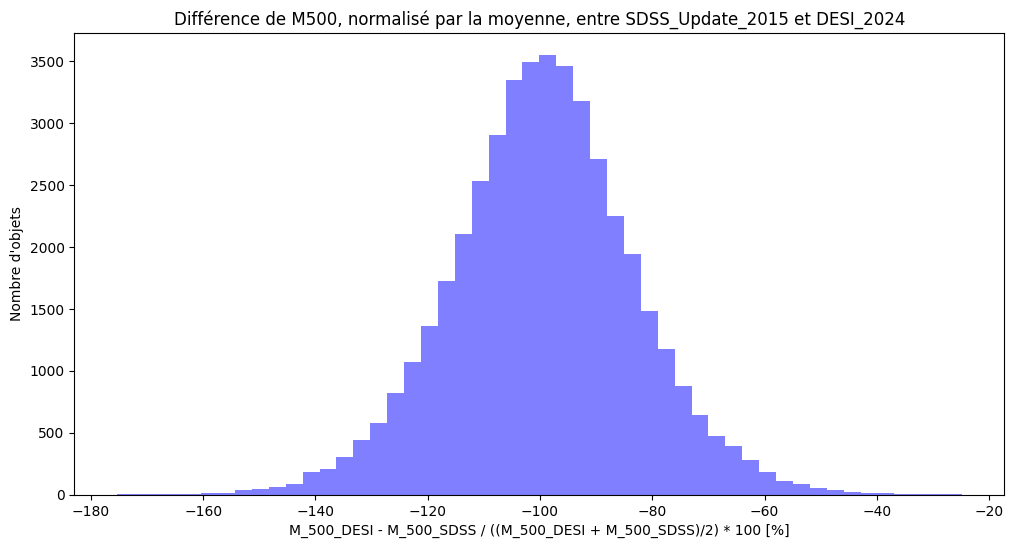

In [17]:
plt.figure(figsize= (12, 6))
plt.hist(diff_mass_normalisée, bins=50, color='blue', alpha=0.5)
plt.xlabel('M_500_DESI - M_500_SDSS / ((M_500_DESI + M_500_SDSS)/2) * 100 [%]')
plt.ylabel('Nombre d\'objets')
plt.title('Différence de M500, normalisé par la moyenne, entre SDSS_Update_2015 et DESI_2024')

'''output_path = os.path.join(folder_plots, "histogramme_diff_M500.png")
plt.savefig(output_path, dpi=300)'''

Text(0.5, 1.0, 'Différence de richesse 500 entre SDSS_Update_2015 et DESI_2024')

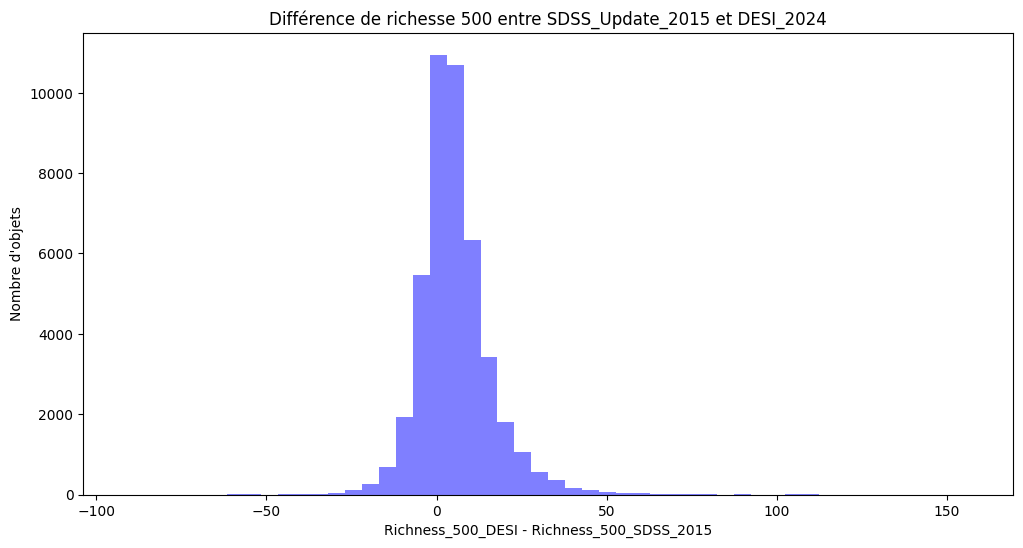

In [18]:
plt.figure(figsize=(12, 6))
plt.hist(diff_richness, bins=50, color='blue', alpha=0.5)
plt.xlabel('Richness_500_DESI - Richness_500_SDSS_2015')
plt.ylabel('Nombre d\'objets')
plt.title('Différence de richesse 500 entre SDSS_Update_2015 et DESI_2024')

Text(0.5, 1.0, 'Différence de richesse 500, normalisée par la moyenne, entre SDSS_Update_2015 et DESI_2024')

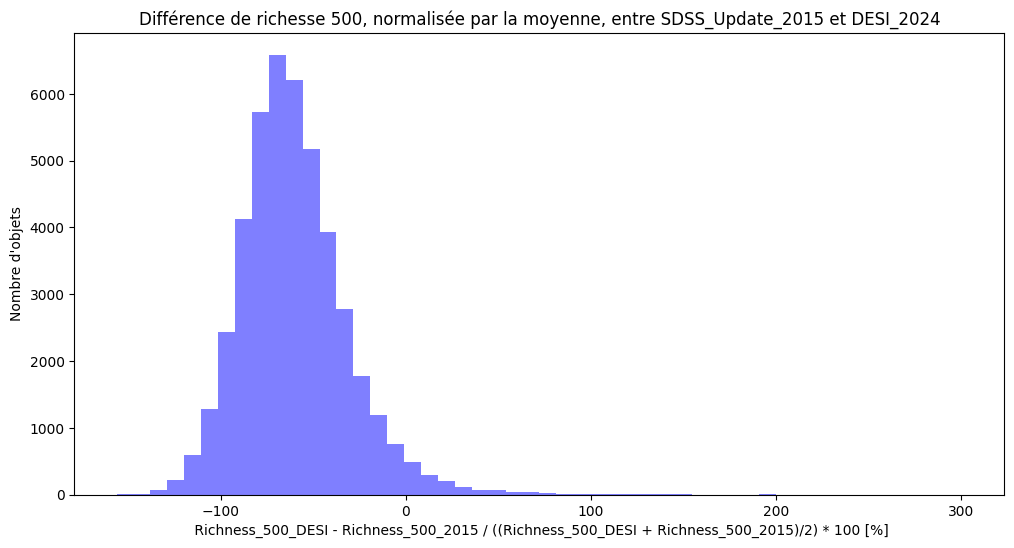

In [19]:
plt.figure(figsize=(12, 6))
plt.hist(diff_richness_normalisée, bins=50, color='blue', alpha=0.5)
plt.xlabel(' Richness_500_DESI - Richness_500_2015 / ((Richness_500_DESI + Richness_500_2015)/2) * 100 [%]')
plt.ylabel('Nombre d\'objets')
plt.title('Différence de richesse 500, normalisée par la moyenne, entre SDSS_Update_2015 et DESI_2024')

## Comparaison SDSS_2012 et DESI_Legacy_2024 (tentative de passage de M200 à M500)

In [20]:
M200SDSS2012 = SDSS_2012_scaling_relation_M200_RL(table_SDSS_2012['RL_'].tolist()) # Each mass is in 10^14 MSun
table_SDSS_2012['M200'] = M200SDSS2012

In [21]:
table_SDSS_2012

,_Glon,_Glat,_RAJ2000,_DEJ2000,WHL,RAJ2000,DEJ2000,zph,zsp,rmag,r200,RL_,N200,Other,M200
0,110.449770,-29.412918,0.00236,32.20925,J000000.6+321233,0.00236,32.20925,0.1274,0.0000,14.92,1.72,70.63,24,Abell \r,4.713216
1,100.049559,-55.283431,0.00957,5.28827,J000002.3+051718,0.00957,5.28827,0.1696,0.0000,16.20,0.94,17.48,9,\r,0.919970
2,110.203228,-30.366812,0.01377,31.23175,J000003.3+311354,0.01377,31.23175,0.5428,0.0000,20.17,0.87,14.27,8,\r,0.725565
3,110.350581,-29.827793,0.01475,31.78564,J000003.5+314708,0.01475,31.78564,0.0932,0.0000,15.18,0.94,16.97,9,\r,0.888644
4,98.226082,-57.913027,0.01945,2.47386,J000004.7+022826,0.01945,2.47386,0.4179,0.0000,19.32,0.95,13.71,10,\r,0.692363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132679,107.667888,-38.665737,359.98712,22.67506,J235956.9+224030,359.98712,22.67506,0.3590,0.0000,18.27,1.00,19.46,11,\r,1.043031
132680,104.152271,-47.689671,359.99329,13.29671,J235958.4+131748,359.99329,13.29671,0.1710,0.0000,16.57,0.91,14.23,11,\r,0.723186
132681,96.879786,-59.541787,359.99500,0.70175,J235958.8+004206,359.99500,0.70175,0.0741,0.0817,14.89,1.01,19.64,11,AMF \r,1.054328
132682,107.386151,-39.528437,359.99677,21.78513,J235959.2+214706,359.99677,21.78513,0.4303,0.0000,18.90,1.00,19.17,11,\r,1.024868


In [22]:
table_DESI_filtered_2 = table_DESI[table_DESI['Cat'].str.contains("WHL", na=False)] # On récupère les objets de la table DESI qui sont dans la table SDSS (WHL = Wen,Hal,Liu)

table_SDSS_2012_filtered = table_SDSS_2012[table_SDSS_2012['WHL'].isin(table_DESI_filtered_2['Name'].tolist())] 
print(len(table_SDSS_2012_filtered)) # Pourquoi on ne récupère pas tous les clusters 'table_DESI_filtered'? → ils sont censés tous correspondre à ceux de SDSS

table_DESI_filtered_2 = table_DESI_filtered_2[table_DESI_filtered_2['Name'].isin(table_SDSS_2012_filtered['WHL'].tolist())] 
print(len(table_DESI_filtered_2))


43083
43083


In [23]:
# Align the rows of table_DESI_filtered_2 to match the order of table_SDSS_2012_filtered['WHL']
table_DESI_filtered_2 = table_DESI_filtered_2.set_index('Name').loc[table_SDSS_2012_filtered['WHL']].reset_index()
table_DESI_filtered_2['Name'].tolist() == table_SDSS_2012_filtered['WHL'].tolist()

True

In [24]:
M200_SDSS_2012 = np.array(table_SDSS_2012_filtered['M200'].tolist()) # Each mass is in 10^14 MSun

In [25]:
M_500_DESI_2 = np.array(table_DESI_filtered_2['M500'].tolist()) 

In [26]:
# Tentative de conversion M200 à M500 : ne pas oublier qu'on à un problème de système sous-déterminé avec le profil de NFW et M200 et R200
# On va tenter d'optimiser le rapport M500/M200 pour avoir le meilleur ajustement possible entre les deux tables

def cost_function_M500_DESI_M200_SDSS2012(ratio):
    value = np.sum((M_500_DESI_2 - ratio * M200_SDSS_2012)**2)
    return value


In [27]:
ratio = np.arange(0.1,0.3,0.01) # On va essayer de trouver le meilleur ratio entre M500 de DESI et M200 de SDSS 2012

optim = scipy.optimize.minimize(cost_function_M500_DESI_M200_SDSS2012, x0=0.2, bounds=[(0.1, 0.3)], method='L-BFGS-B') #' L-BFGS-B is a quasi-Newton method that is efficient for problems with bound constraints' → si temps voir si il n'y a pas de meilleure option

In [28]:
optim

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 70600.01247515056
        x: [ 3.000e-01]
      nit: 1
      jac: [-1.192e+05]
     nfev: 4
     njev: 2
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>